# Data Science para Detecção de Câncer de Pele
## Análise de Imagens Médicas com Inteligência Artificial

In [1]:
# Versão do Python
from platform import python_version
print('Versão do Python usada neste Jupyter Notebook:', python_version())

Versão do Python usada neste Jupyter Notebook: 3.8.2


## Objetivo

Construir um Modelo Convolucional Profundo para reconhecer lesões de câncer de pele em imagens.

## Fonte de Dados e Arquivos de Imagens e Metadados

https://dataverse.harvard.edu/


https://challenge2019.isic-archive.com/

## Arquivos

**Training Data**

- ISIC_2019_Training_Input.zip
- 25,331 imagens jpg


- ISIC_2019_Training_Metadata.csv
- 25,331 registros de metadados com idade, sexo, anatomia geral e identificador de lesão


- ISIC_2019_Training_GroundTruth.csv
- 25,331 registros de diganósticos de lesões, um para cada imagem (labels)


**Test Data**

- ISIC_2019_Test_Input.zip
- 8,238 imagens jpg de lesões de imagens


- ISIC_2019_Test_Metadata.csv
- 8,238 registros de metadados com idade, sexo e anatomia geral 

## Dicionário de dados

O objetivo do dataser ISIC 2019 é classificar imagens dermatoscópias entre nove categorias diferentes de diagnósticos:

#### Classes:
- Melanoma
- Melanocytic nevus 
- Basal cell carcinoma
- Actinic keratosis
- Benign keratosis (solar lentigo / seborrheic keratosis / lichen planus-like keratosis)
- Dermatofibroma
- Vascular lesion
- Squamous cell carcinoma
- None of the others

#### Legenda:
- MEL = Melanoma
- NV = Melanocytic nevus 
- BCC = Basal cell carcinoma
- AK = Actinic keratosis
- BKL = Benign keratosis (solar lentigo / seborrheic keratosis / lichen planus-like keratosis)
- DF = Dermatofibroma
- VASC = Vascular lesion
- SCC = Squamous cell carcinoma
- UNK = None of the others

Esse é o conteúdo do arquivo **ISIC_2019_Training_GroundTruth.csv**, para cada imagem.

## Instalando e carregando os pacotes

In [ ]:
!nvidia-smi

In [ ]:
# Instala o pacote watermark.
# Esse pacote é usado para gravar as versões de outros pacotes usados nesse jupyter notebook.
!pip install -q -U watermark

In [ ]:
# Pacote para criar modelo portável
# https://github.com/plaidml/plaidml
!pip install -q plaidml

In [ ]:
# Plaidml para o Keras
!pip install -q plaidml.keras

In [5]:
# Instala o pacote tensorflow.
# Esse pacote é usado para aprendizado de máquina.
!pip install tensorflow

In [144]:
#Imports para manipulação e visualização de dados
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

#Imports para manipulação de imagens
import os 
import sklearn
from PIL import Image
from sklearn.model_selection import train_test_split

#Imports para cálculo e utilitários
import itertools
from sklearn.utils.multiclass import unique_labels
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#Imports para Deep Learning
import plaidml
import plaidml.keras
import tensorflow
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, MaxPool2D
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.layers import Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical
from keras.applications import InceptionV3
from keras.applications.inception_v3 import preprocess_input

#Desativa mensagens do Pandas e Matplotlib. 
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action = "ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = matplotlib.cbook.mplDeprecation)

%matplotlib inline

In [7]:
#Define o Keras Backend
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

In [8]:
#Versões dos pacotes usados neste Jupyter Notebook
%reload_ext watermark
%watermark -a "Data Science para Detecção de Câncer de Pele" --iversions

pandas     1.1.1
tensorflow 2.3.0
matplotlib 3.3.1
sklearn    0.23.1
PIL.Image  7.2.0
numpy      1.18.5
keras      2.2.4
Data Science para Detecção de Câncer de Pele


# Checando o Hardware disponível no servidor - CPU e GPUs

In [9]:
# Lista todos os dispositivos disponiveis
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1336052056325338784
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2906556928331636955
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15864582272173892776
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 10504189218614453655
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:2"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15183897662136159631
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 23558355712
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13586321226334621172
physical_device_desc: "device: 0, name: TITAN RTX, pci bus id: 

In [10]:
# pip uninstall tensorflow
# pip install tensorflow

In [11]:
import tensorflow as tf
print("Número disponível de GPUs:", len(tf.config.experimental.list_physical_devices("GPU")))

Número disponível de GPUs: 3


In [12]:
# Lista o código de cada GPU
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]

# Carregando os dados

In [13]:
# Carregando o conjunto de dados de mapeamento imagem/classe
dataset = pd.read_csv("/media/datasets/IAMED/Cap03/ISIC_2019_Training_GroundTruth.csv")

In [14]:
# Visualiza o dataset
dataset

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
25327,ISIC_0073248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25328,ISIC_0073249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25329,ISIC_0073251,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Legenda:
- MEL = Melanoma
- NV = Melanocytic nevus 
- BCC = Basal cell carcinoma
- AK = Actinic keratosis
- BKL = Benign keratosis (solar lentigo / seborrheic keratosis / lichen planus-like keratosis)
- DF = Dermatofibroma
- VASC = Vascular lesion
- SCC = Squamous cell carcinoma
- UNK = None of the others

In [15]:
# Calculando a quantidade total de imagens por classe
dataset.groupby(['MEL','NV','BCC','AK','BKL','DF','VASC','SCC','UNK']).size().unstack(fill_value=0)

UNK                                 0.0
MEL NV  BCC AK  BKL DF  VASC SCC       
0.0 0.0 0.0 0.0 0.0 0.0 0.0  1.0    628
                        1.0  0.0    253
                    1.0 0.0  0.0    239
                1.0 0.0 0.0  0.0   2624
            1.0 0.0 0.0 0.0  0.0    867
        1.0 0.0 0.0 0.0 0.0  0.0   3323
    1.0 0.0 0.0 0.0 0.0 0.0  0.0  12875
1.0 0.0 0.0 0.0 0.0 0.0 0.0  0.0   4522

## Limpeza e transformação de dados

In [16]:
#Renomeia a coluna com o id da imagem
dataset.rename(columns = { 'image': 'image_id' }, inplace = True)

In [17]:
#Visualiza os dados
dataset.head()

,image_id,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
#Cria uma nova coluna e atribuí o valor da coluna 'UNK'
dataset['cancer_classification'] = dataset['UNK']

In [19]:
#Pecorre as classes e atribuí a classificação do cancer encontrado na coluna 'cancer_classification'
for index, row in dataset.iterrows():
    dataset['cancer_classification'][index] = (row == 1.0).idxmax(axis = 1)

In [20]:
# Visualiza os dados
dataset.tail(10)

,image_id,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,cancer_classification
25321,ISIC_0073240,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
25322,ISIC_0073241,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL
25323,ISIC_0073244,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
25324,ISIC_0073245,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
25325,ISIC_0073246,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,BCC
25326,ISIC_0073247,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,BCC
25327,ISIC_0073248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,BKL
25328,ISIC_0073249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL
25329,ISIC_0073251,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
25330,ISIC_0073254,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,BKL


In [21]:
#Remove colunas desnecessárias
dataset = dataset.drop(['MEL','NV','BCC','AK','BKL','DF','VASC','SCC','UNK'], axis = 1)

In [22]:
#Visualiza os dados
dataset.head()

,image_id,cancer_classification
0,ISIC_0000000,NV
1,ISIC_0000001,NV
2,ISIC_0000002,MEL
3,ISIC_0000003,NV
4,ISIC_0000004,MEL


In [23]:
#Visualiza os valores únicos
dataset['cancer_classification'].unique()

array(['NV', 'MEL', 'BKL', 'DF', 'SCC', 'BCC', 'VASC', 'AK'], dtype=object)

#### Legenda:
- MEL = Melanoma
- NV = Melanocytic nevus 
- BCC = Basal cell carcinoma
- AK = Actinic keratosis
- BKL = Benign keratosis (solar lentigo / seborrheic keratosis / lichen planus-like keratosis)
- DF = Dermatofibroma
- VASC = Vascular lesion
- SCC = Squamous cell carcinoma
- UNK = None of the others

In [24]:
#Número de linhas/coluna do dataset
dataset.shape

(25331, 2)

In [25]:
#Total de registro por classe
dataset['cancer_classification'].value_counts()

NV      12875
MEL      4522
BCC      3323
BKL      2624
AK        867
SCC       628
VASC      253
DF        239
Name: cancer_classification, dtype: int64

In [26]:
#Remove os registros das classes com menos amostras
dataset = dataset[dataset.cancer_classification != 'DF']
dataset = dataset[dataset.cancer_classification != 'VASC']
dataset = dataset[dataset.cancer_classification != 'SCC']
dataset = dataset[dataset.cancer_classification != 'AK']
dataset = dataset[dataset.cancer_classification != 'UNK']

In [27]:
#Verificamos a proporção
dataset.cancer_classification.value_counts()

NV     12875
MEL     4522
BCC     3323
BKL     2624
Name: cancer_classification, dtype: int64

In [28]:
#Número de linhas/coluna do dataset
dataset.shape

(23344, 2)

#### Aplica label encoding na coluna cancer_classification (converte texto para um valor numérico correspondente em uma outra coluna)

In [29]:
#Visualiza os dados
dataset.head()

,image_id,cancer_classification
0,ISIC_0000000,NV
1,ISIC_0000001,NV
2,ISIC_0000002,MEL
3,ISIC_0000003,NV
4,ISIC_0000004,MEL


In [30]:
#Label encoding
dataset['cancer_classification_idx'] = pd.Categorical(dataset['cancer_classification']).codes

In [31]:
#Visualiza os dados
dataset.head()

,image_id,cancer_classification,cancer_classification_idx
0,ISIC_0000000,NV,3
1,ISIC_0000001,NV,3
2,ISIC_0000002,MEL,2
3,ISIC_0000003,NV,3
4,ISIC_0000004,MEL,2


In [32]:
#Visualiza os valores únicos
dataset['cancer_classification_idx'].unique()

array([3, 2, 1, 0], dtype=int8)

## Limpeza e transformação das imagens

In [33]:
#Carrega a lista de imagens para treinamento
images = os.listdir('/media/datasets/IAMED/Cap03/ISIC_2019_Training_Input/')

In [34]:
#Lista amostra das imagens
images[1:5]

['ISIC_0066102.jpg',
 'ISIC_0058433.jpg',
 'ISIC_0057942.jpg',
 'ISIC_0024315.jpg']

In [35]:
#Tamanho da lista de imagens
len(images)

25333

In [36]:
#Função para extrair o caminho de cada imagem, concatena com o nome da imagem no dataframe e adiciona a extensão .jpg
def extract_image_path(x):
    file = x + '.jpg'
    return os.path.join('/media/datasets/IAMED/Cap03/ISIC_2019_Training_Input/', file)

In [37]:
#Aplica a função à coluna image_id e grava o resultado na coluna image
dataset['image'] = dataset['image_id'].apply(extract_image_path)

In [38]:
#Visualiza os dados
dataset.head()

,image_id,cancer_classification,cancer_classification_idx,image
0,ISIC_0000000,NV,3,/media/datasets/IAMED/Cap03/ISIC_2019_Training...
1,ISIC_0000001,NV,3,/media/datasets/IAMED/Cap03/ISIC_2019_Training...
2,ISIC_0000002,MEL,2,/media/datasets/IAMED/Cap03/ISIC_2019_Training...
3,ISIC_0000003,NV,3,/media/datasets/IAMED/Cap03/ISIC_2019_Training...
4,ISIC_0000004,MEL,2,/media/datasets/IAMED/Cap03/ISIC_2019_Training...


### Balanceamento de Classe para Classificação Multiclasse

> Undersampling - Remove aleatoriamente as amostras da classe majoritária

In [39]:
#Shape
dataset.shape

(23344, 4)

In [40]:
#Proporção de registros por classe
dataset.cancer_classification.value_counts()

NV     12875
MEL     4522
BCC     3323
BKL     2624
Name: cancer_classification, dtype: int64

In [41]:
#Proporção de registros por classe em valor percentual
dataset.cancer_classification.value_counts() / dataset.shape[0] * 100

NV     55.153358
MEL    19.371145
BCC    14.234921
BKL    11.240576
Name: cancer_classification, dtype: float64

In [42]:
#Separa os registros da classe NV das demais
df_nv = dataset[dataset['cancer_classification'] == 'NV']

In [43]:
#Separa das demais classes
df_no_nv = dataset[dataset['cancer_classification'] != 'NV']

In [44]:
#Shuffle - Embaralha os dados de maneira aleatória
df_nv = shuffle(df_nv)

In [45]:
#Total de registros da classe NV
df_nv.count()

image_id                     12875
cancer_classification        12875
cancer_classification_idx    12875
image                        12875
dtype: int64

In [46]:
# Cria novo dataframe com 4600 registros
df_nv = df_nv.head(4600)

In [47]:
#Visualiza os dados
df_nv.head()

,image_id,cancer_classification,cancer_classification_idx,image
12030,ISIC_0033433,NV,3,/media/datasets/IAMED/Cap03/ISIC_2019_Training...
24365,ISIC_0071748,NV,3,/media/datasets/IAMED/Cap03/ISIC_2019_Training...
24358,ISIC_0071735,NV,3,/media/datasets/IAMED/Cap03/ISIC_2019_Training...
10352,ISIC_0031755,NV,3,/media/datasets/IAMED/Cap03/ISIC_2019_Training...
20429,ISIC_0065506,NV,3,/media/datasets/IAMED/Cap03/ISIC_2019_Training...


In [48]:
#Reset do índice
df_nv = df_nv.reset_index(drop = True)

In [49]:
#Visualiza os dados
df_nv.head()

,image_id,cancer_classification,cancer_classification_idx,image
0,ISIC_0033433,NV,3,/media/datasets/IAMED/Cap03/ISIC_2019_Training...
1,ISIC_0071748,NV,3,/media/datasets/IAMED/Cap03/ISIC_2019_Training...
2,ISIC_0071735,NV,3,/media/datasets/IAMED/Cap03/ISIC_2019_Training...
3,ISIC_0031755,NV,3,/media/datasets/IAMED/Cap03/ISIC_2019_Training...
4,ISIC_0065506,NV,3,/media/datasets/IAMED/Cap03/ISIC_2019_Training...


In [50]:
#Concatena os registros da classe NV com os registros das demais classes
final_dataset = pd.concat([df_nv, df_no_nv])

In [51]:
#Shape
final_dataset.shape

(15069, 4)

In [52]:
#Proporção das classes
final_dataset.cancer_classification.value_counts()

NV     4600
MEL    4522
BCC    3323
BKL    2624
Name: cancer_classification, dtype: int64

In [53]:
#Proporção de registros por classe em valor percentual
final_dataset.cancer_classification.value_counts() / final_dataset.shape[0] * 100

NV     30.526246
MEL    30.008627
BCC    22.051895
BKL    17.413232
Name: cancer_classification, dtype: float64

### Prepara as amostras de Teste

Separa algumas amostras para avaliar o modelo treinado.

In [54]:
# Shape
final_dataset.shape

(15069, 4)

In [55]:
#Registros de teste para a classe NV
df_nv = final_dataset[final_dataset['cancer_classification'] == 'NV']
df_nv = shuffle(df_nv)
df_nv = df_nv.head(100)
df_nv = df_nv.reset_index(drop = True)

In [56]:
#Registros de teste para a classe MEL
df_mel = final_dataset[final_dataset['cancer_classification'] == 'MEL']
df_mel = shuffle(df_mel)
df_mel = df_mel.head(100)
df_mel = df_mel.reset_index(drop = True)

In [57]:
#Registros de teste para a classe BCC
df_bcc = final_dataset[final_dataset['cancer_classification'] == 'BCC']
df_bcc = shuffle(df_bcc)
df_bcc = df_bcc.head(100)
df_bcc = df_bcc.reset_index(drop = True)

In [58]:
#Registros de teste para a classe BKL
df_bkl = final_dataset[final_dataset['cancer_classification'] == 'BKL']
df_bkl = shuffle(df_bkl)
df_bkl = df_bkl.head(100)
df_bkl = df_bkl.reset_index(drop = True)

In [59]:
#Concatena as amostras de teste em um novo dataframe
df_test = pd.concat([df_bcc, df_bkl, df_mel, df_nv])

In [60]:
#Embaralha os dados
df_test = shuffle(df_test)

In [61]:
#Reset do índice
df_test = df_test.reset_index(drop = True)

In [62]:
#Checamos a proporção de registros por classe
df_test.cancer_classification.value_counts()

BCC    100
BKL    100
NV     100
MEL    100
Name: cancer_classification, dtype: int64

In [63]:
#Visualiza os dados
df_test.head()

,image_id,cancer_classification,cancer_classification_idx,image
0,ISIC_0028051,MEL,2,/media/datasets/IAMED/Cap03/ISIC_2019_Training...
1,ISIC_0062129,BCC,0,/media/datasets/IAMED/Cap03/ISIC_2019_Training...
2,ISIC_0024515,BCC,0,/media/datasets/IAMED/Cap03/ISIC_2019_Training...
3,ISIC_0058887,MEL,2,/media/datasets/IAMED/Cap03/ISIC_2019_Training...
4,ISIC_0031255,NV,3,/media/datasets/IAMED/Cap03/ISIC_2019_Training...


### Prepara as amostras de Treino

Filtra do dataset original todas as imagens que foram colocadas no dataset de teste.

In [64]:
#Cria o dataset de treino
df_training = final_dataset

In [65]:
#Shape
final_dataset.shape

(15069, 4)

In [66]:
#Shape
df_training.shape

(15069, 4)

In [67]:
#Shape
df_test.shape

(400, 4)

In [68]:
#Cria uma lista de valores das colunas
keys = list(final_dataset.columns.values)

In [69]:
#Define os índices dos datasets de treino e teste
i1 = df_training.set_index(keys).index
i2 = df_test.set_index(keys).index

In [70]:
#Filtra o dataset de treino com todas as imagens que não estão no dataset de teste
df_training = df_training[~i1.isin(i2)]

In [71]:
#Shape
df_training.shape

(14669, 4)

In [72]:
#Verifica uma imagem de teste
df_test['image'][10]

'/media/datasets/IAMED/Cap03/ISIC_2019_Training_Input/ISIC_0070962.jpg'

In [73]:
#Checa se a imagem de teste está no dataset de treino
'/media/datasets/IAMED/Cap03/ISIC_2019_Training_Input/ISIC_0070962.jpg' in df_training.image.values

False

In [74]:
#Reset do índice
df_training = df_training.reset_index(drop = True)

In [75]:
df_training.head()

,image_id,cancer_classification,cancer_classification_idx,image
0,ISIC_0033433,NV,3,/media/datasets/IAMED/Cap03/ISIC_2019_Training...
1,ISIC_0071748,NV,3,/media/datasets/IAMED/Cap03/ISIC_2019_Training...
2,ISIC_0071735,NV,3,/media/datasets/IAMED/Cap03/ISIC_2019_Training...
3,ISIC_0031755,NV,3,/media/datasets/IAMED/Cap03/ISIC_2019_Training...
4,ISIC_0065506,NV,3,/media/datasets/IAMED/Cap03/ISIC_2019_Training...


### Redimensionamento das Imagens

Reduz o tamanho das imagens para acelerar o treinamento e usar os recursos computacionais disponíveis.

In [76]:
#Verifica uma imagem
df_training['image'][10]

'/media/datasets/IAMED/Cap03/ISIC_2019_Training_Input/ISIC_0026920.jpg'

In [77]:
#Buscar uma imagem qualquer no dataset de treino
image_path =  df_training['image'][10]

In [78]:
#Visualiza a imagem
image = Image.open(image_path)

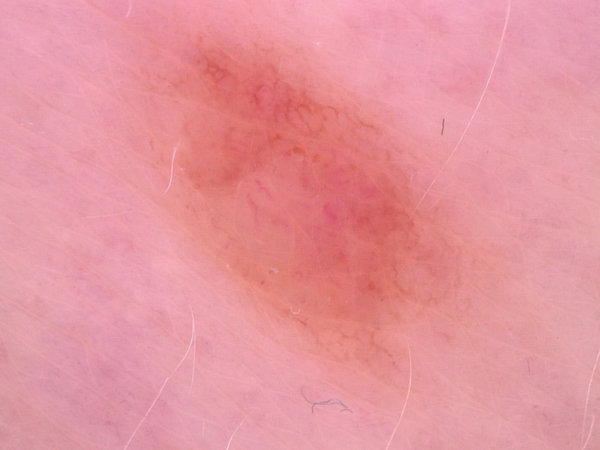

In [79]:
image

In [80]:
#Tamanho da imagem em pixels
image.size

(600, 450)

In [81]:
#Largura
image.width

600

In [82]:
#Altura
image.height

450

**Redimensiona as imagens de treino**

In [83]:
%%time
df_training['image_matrix'] = df_training['image'].map(lambda x: np.asarray(Image.open(x).resize((112, 112))))

CPU times: user 4min 13s, sys: 1.52 s, total: 4min 15s
Wall time: 4min 16s


In [84]:
#Reset do índice
df_training.set_index("image_id", inplace = True)

In [85]:
#Shape do dataframe
df_training.shape

(14669, 4)

In [86]:
#Shape de uma imagem
df_training.image_matrix[0].shape

(112, 112, 3)

In [87]:
#Visualiza os dados
df_training.head()

,cancer_classification,cancer_classification_idx,image,image_matrix
image_id,,,,
ISIC_0033433,NV,3,/media/datasets/IAMED/Cap03/ISIC_2019_Training...,"[[[28, 19, 17], [36, 22, 22], [40, 27, 26], [4..."
ISIC_0071748,NV,3,/media/datasets/IAMED/Cap03/ISIC_2019_Training...,"[[[177, 163, 147], [171, 157, 148], [159, 138,..."
ISIC_0071735,NV,3,/media/datasets/IAMED/Cap03/ISIC_2019_Training...,"[[[125, 130, 142], [129, 135, 151], [134, 141,..."
ISIC_0031755,NV,3,/media/datasets/IAMED/Cap03/ISIC_2019_Training...,"[[[198, 89, 109], [195, 82, 102], [197, 79, 10..."
ISIC_0065506,NV,3,/media/datasets/IAMED/Cap03/ISIC_2019_Training...,"[[[1, 1, 1], [0, 0, 0], [1, 1, 1], [1, 1, 1], ..."


**Redimensiona as imagens de teste**

In [88]:
%%time
df_test['image_matrix'] = df_test['image'].map(lambda x: np.asarray(Image.open(x).resize((112, 112))))

CPU times: user 6.99 s, sys: 24.2 ms, total: 7.01 s
Wall time: 7.03 s


In [89]:
#Reset do índice
df_test.set_index("image_id", inplace = True)

In [90]:
#Shape do dataframe
df_test.shape

(400, 4)

In [91]:
#Shape de uma imagem
df_test.image_matrix[0].shape

(112, 112, 3)

In [92]:
#Visualiza os dados
df_test.head()

,cancer_classification,cancer_classification_idx,image,image_matrix
image_id,,,,
ISIC_0028051,MEL,2,/media/datasets/IAMED/Cap03/ISIC_2019_Training...,"[[[162, 128, 145], [169, 139, 152], [170, 142,..."
ISIC_0062129,BCC,0,/media/datasets/IAMED/Cap03/ISIC_2019_Training...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
ISIC_0024515,BCC,0,/media/datasets/IAMED/Cap03/ISIC_2019_Training...,"[[[161, 117, 132], [165, 122, 133], [171, 128,..."
ISIC_0058887,MEL,2,/media/datasets/IAMED/Cap03/ISIC_2019_Training...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [1, 1, 1], ..."
ISIC_0031255,NV,3,/media/datasets/IAMED/Cap03/ISIC_2019_Training...,"[[[207, 108, 108], [210, 110, 109], [205, 100,..."


Visualiza algumas imagens para verificação

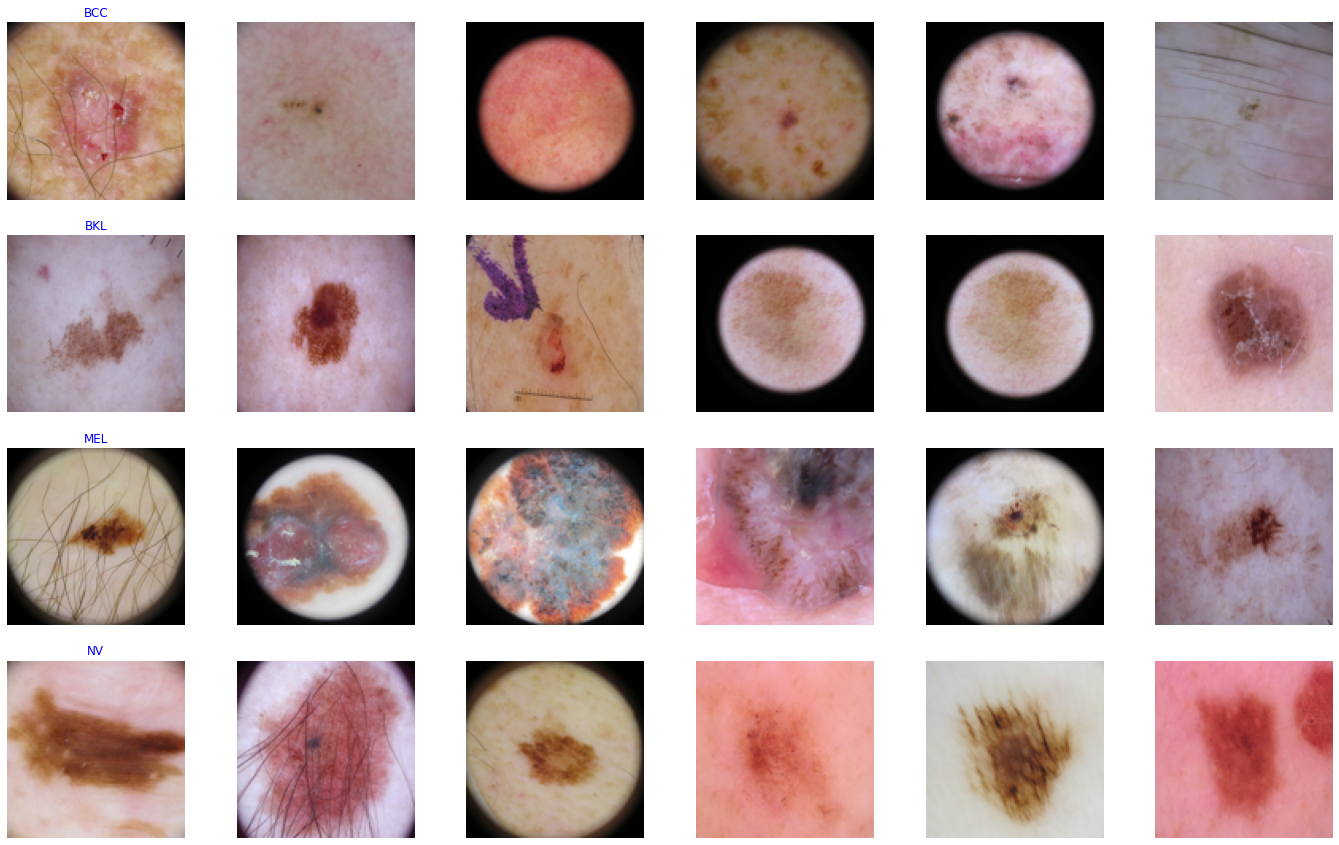

In [93]:
#Número de amostras
n_samples = 6

#Figura e subplots
fig, m_axs = plt.subplots(4, n_samples, figsize = (4 * n_samples, 3 * 5))

#Retorna o nome da classe e o número de imagens da classe
for n_axs, (type_name, type_rows) in zip(m_axs, df_training.sort_values(['cancer_classification']).groupby('cancer_classification')):
    
    #Título de cada classe
    n_axs[0].set_title(type_name, color = 'blue')
    
    #Busca amostras randômicas do total de imagens
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state = 1234).iterrows()):
        c_ax.imshow(c_row['image_matrix'])
        c_ax.axis('off')

Checa se todas as dimensões estão corretas

In [94]:
#Total de amostras em treino
df_training['image_matrix'].map(lambda x: x.shape).value_counts()

(112, 112, 3)    14669
Name: image_matrix, dtype: int64

In [95]:
#Amostras por classe em treino
df_training.cancer_classification.value_counts()

NV     4500
MEL    4422
BCC    3223
BKL    2524
Name: cancer_classification, dtype: int64

In [96]:
#Total de amostras em teste
df_test['image_matrix'].map(lambda x: x.shape).value_counts()

(112, 112, 3)    400
Name: image_matrix, dtype: int64

In [97]:
#Amostras por classe em teste
df_test.cancer_classification.value_counts()

BCC    100
BKL    100
NV     100
MEL    100
Name: cancer_classification, dtype: int64

### Divisão em Dados de Treino e Validação (teste durante o treinamento)

In [98]:
#Aplica aleatoriedade nos registros
df_training = shuffle(df_training)
df_test = shuffle(df_test)

In [99]:
#Coloca as colunas com o valor numérico de cada classe em y (variável target)
y_training = df_training['cancer_classification_idx']
y_test = df_test['cancer_classification_idx']

In [100]:
#Shape em treino
y_training.shape

(14669,)

In [101]:
#Shape em teste
y_test.shape

(400,)

In [102]:
#Proporção de classe em treino
y_training.value_counts()

3    4500
2    4422
0    3223
1    2524
Name: cancer_classification_idx, dtype: int64

In [103]:
#Proporção de classe em teste
y_test.value_counts()

3    100
2    100
1    100
0    100
Name: cancer_classification_idx, dtype: int64

In [104]:
#Converte y para o tipo categórico
y_training = to_categorical(y_training, num_classes = 4)
y_test = to_categorical(y_test, num_classes = 4)

In [105]:
#Shape em treino
y_training.shape

(14669, 4)

In [106]:
#Shape em teste
y_test.shape

(400, 4)

Prepara a variável de entrada (imagens)

In [107]:
#Extrai somente as imagens do dataframe, converte para lista e cria o array NumPy
x_training = np.asarray(df_training['image_matrix'].tolist())
x_test = np.asarray(df_test['image_matrix'].tolist())

In [108]:
#Calcula média e desvio padrão para normalizar as imagens de treino
x_training_mean = np.mean(x_training)
x_training_std = np.std(x_training)

In [109]:
#Calcula média e desvio padrão para normalizar as imagens de teste
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

Os valores de pixels estão em unidades diferentes

Aplica normalização dos pixels para mesma escala

In [110]:
#Normaliza em treino
x_training = (x_training - x_training_mean) / x_training_std

In [111]:
#Normaliza em teste
x_test = (x_test - x_test_mean) / x_test_std

In [112]:
#Shape em treino
x_training.shape

(14669, 112, 112, 3)

In [113]:
# Shape em teste
x_test.shape

(400, 112, 112, 3)

Divide os dados em treino e validação

In [114]:
#Divisão em treino e validação
x_training, x_valid, y_training, y_valid = train_test_split(x_training, 
                                                        y_training, 
                                                        test_size = 0.1, 
                                                        random_state = 42)

In [115]:
#Shape
print("Shape de x_training =", x_training.shape)
print("Shape de y_training =", y_training.shape)
print("Shape de x_valid =", x_valid.shape)
print("Shape de y_valid =", y_valid.shape)

Shape de x_training = (13202, 112, 112, 3)
Shape de y_training = (13202, 4)
Shape de x_valid = (1467, 112, 112, 3)
Shape de y_valid = (1467, 4)


In [116]:
#Ajusta o shape
x_training = x_training.reshape(x_training.shape[0], *(112, 112, 3))
x_valid = x_valid.reshape(x_valid.shape[0], *(112, 112, 3))

In [117]:
#Shape
print("Shape de x_training =", x_training.shape)
print("Shape de y_training =", y_training.shape)
print("Shape de x_valid =", x_valid.shape)
print("Shape de y_valid =", y_valid.shape)

Shape de x_training = (13202, 112, 112, 3)
Shape de y_training = (13202, 4)
Shape de x_valid = (1467, 112, 112, 3)
Shape de y_valid = (1467, 4)


### Construção do Modelo

<br />

> **Rede Neural Convolucional Profunda** (Deep Convolutional Network) para o reconhecimento das imagens.

> **Arquitetura InceptionV3** com um modelo pré-treinado oferecido pelo Keras e com algumas camadas ao final para customizar as saídas da rede.

In [118]:
#Hiperparâmetros

#Shape das imagens
input_shape = (112, 112, 3)

#Número de classes a prever
num_classes = 4 

#Número de épocas de treinamento
epochs = 50

#Tamanho do batch
batch_size = 32

#Taxa de aprendizado
lr_param = 0.0001

#Parâmetros beta
beta_1_param = 0.9
beta_2_param = 0.999

#Decay
decay_param = 0.0

#Passos por época
steps_per_epoch_param = x_training.shape[0] // batch_size

**Transferência de Aprendizado**

In [119]:
#Cria o modelo base
base_model = tf.keras.applications.InceptionV3(weights = 'imagenet', 
                                                include_top = False, 
                                                input_shape = input_shape)

In [120]:
#Sumário do modelo base
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 55, 55, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 55, 55, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 55, 55, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [121]:
#Adicion nossas camadas ao base_model

#Cria a sequência de camadas
add_model = Sequential()

#Adiciona primeiro o modelo base
add_model.add(base_model)

#Precisa de uma camada global de Pooling
add_model.add(GlobalAveragePooling2D())

#Dropout para regularização e evitar overfitting
add_model.add(Dropout(0.5))

#Camada densa na camada final com ativação softmax para previsão das probabilidades das classes
add_model.add(Dense(num_classes, activation = 'softmax'))

In [122]:
#Cria o modelo final
final_model = add_model

In [123]:
#Sumário do modelo final
final_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2, 2, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 8196      
Total params: 21,810,980
Trainable params: 21,776,548
Non-trainable params: 34,432
_________________________________________________________________


In [124]:
#Cria o otimizador
optimizer = Adam(lr = lr_param, 
                  beta_1 = beta_1_param, 
                  beta_2 = beta_2_param, 
                  epsilon = None, 
                  decay = decay_param, 
                  amsgrad = False)

In [125]:
#Compila o modelo com o otimizador, função de custo e métricas que serão extraídas no treinamento
final_model.compile(optimizer = optimizer, 
                     loss = "categorical_crossentropy", 
                     metrics = ["accuracy"])

In [126]:
#Regra para a redução da taxa de aprendizado
reduces_learning_rate = ReduceLROnPlateau(monitor = 'val_accuracy', 
                                           patience = 3, 
                                           verbose = 1, 
                                           factor = 0.5, 
                                           min_lr = 0.00001)

In [127]:
#Gerador de dados para o treinamento
datagen = ImageDataGenerator(featurewise_center = False,  
                             samplewise_center = False,  
                             featurewise_std_normalization = False,  
                             samplewise_std_normalization = False, 
                             zca_whitening = False,  
                             rotation_range = 10,  
                             zoom_range = 0.1, 
                             width_shift_range = 0.1,  
                             height_shift_range = 0.1,  
                             horizontal_flip = False,  
                             vertical_flip = False) 

### Treinamento do Modelo

In [128]:
%%time

print("\nIniciando o Treinamento do Modelo.\n")

history = final_model.fit(datagen.flow(x_training, 
                                        y_training, 
                                        batch_size = batch_size),
                           epochs = epochs, 
                           validation_data = (x_valid, y_valid),
                           verbose = 1, 
                           steps_per_epoch = steps_per_epoch_param, 
                           callbacks = [reduces_learning_rate])

print("\nTreinamento Concluído.\n")


Iniciando o Treinamento do Modelo.

Epoch 1/50
412/412 [==============================] - 32s 78ms/step - loss: 1.0467 - accuracy: 0.5682 - val_loss: 0.8455 - val_accuracy: 0.6564
Epoch 2/50
412/412 [==============================] - 30s 73ms/step - loss: 0.7760 - accuracy: 0.6894 - val_loss: 0.7281 - val_accuracy: 0.6960
Epoch 3/50
412/412 [==============================] - 30s 74ms/step - loss: 0.6637 - accuracy: 0.7371 - val_loss: 0.7547 - val_accuracy: 0.7035
Epoch 4/50
412/412 [==============================] - 30s 74ms/step - loss: 0.5826 - accuracy: 0.7759 - val_loss: 0.7102 - val_accuracy: 0.7273
Epoch 5/50
412/412 [==============================] - 30s 74ms/step - loss: 0.5039 - accuracy: 0.8047 - val_loss: 0.6995 - val_accuracy: 0.7294
Epoch 6/50
412/412 [==============================] - 30s 73ms/step - loss: 0.4437 - accuracy: 0.8279 - val_loss: 0.7955 - val_accuracy: 0.7096
Epoch 7/50
412/412 [==============================] - 31s 74ms/step - loss: 0.3887 - accuracy: 0.85

### Avaliação do Modelo

In [129]:
#Histórico de treinamento
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

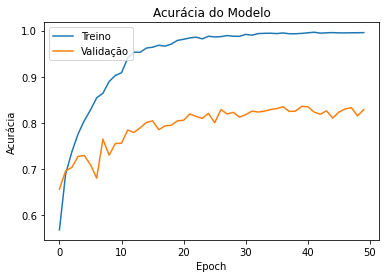

In [130]:
#Plot da Acurácia
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Acurácia do Modelo')
plt.ylabel('Acurácia')
plt.xlabel('Epoch')
plt.legend(['Treino', 'Validação'], loc = 'upper left')
plt.show()

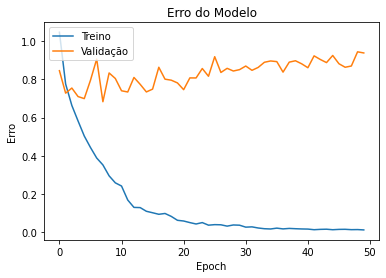

In [131]:
#Plot do Erro
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Erro do Modelo')
plt.ylabel('Erro')
plt.xlabel('Epoch')
plt.legend(['Treino', 'Validação'], loc = 'upper left')
plt.show()

In [133]:
#Calcula as métricas com dados de validação para comparar com a performance em teste
loss_v, accuracy_v = final_model.evaluate(x_valid, y_valid, verbose = 1)

46/46 [==============================] - 1s 14ms/step - loss: 0.9384 - accuracy: 0.8289


In [135]:
#Calcula as métricas com dados de teste
loss, accuracy = final_model.evaluate(x_test, y_test, verbose = 1)

13/13 [==============================] - 0s 28ms/step - loss: 1.0745 - accuracy: 0.8125


In [136]:
print("Acurácia em Validação = %f  ;  loss_v = %f" % (accuracy_v, loss_v))

Acurácia em Validação = 0.828903  ;  loss_v = 0.938383


In [137]:
print("Acurácia em Teste = %f  ;  loss = %f" % (accuracy, loss))

Acurácia em Teste = 0.812500  ;  loss = 1.074516


#### Previsões com o modelo em dados de teste

In [140]:
#Previsões do modelo com dados de teste
Y_pred = final_model.predict(x_test)

In [141]:
#Converte as previsões de classe em teste para One-hot encoding
Y_pred_classes = np.argmax(Y_pred, axis = 1) 

In [142]:
#Extrai o label real das classes
Y_true_classes = np.argmax(y_test, axis = 1) 

In [145]:
#Cria a Matriz de Confusão
print(confusion_matrix(Y_true_classes, Y_pred_classes))

[[82  8  6  4]
 [ 3 82  9  6]
 [ 2  8 83  7]
 [ 1  9 12 78]]


In [146]:
#Grava a Matriz de Confusão
matriz = confusion_matrix(Y_true_classes, Y_pred_classes)

In [147]:
#Lista de classes
classes = ['bcc','bkl','mel', 'nv']

In [148]:
#Função para o plot
def plot_confusion_matrix(cm, 
                          classes,
                          normalize = False,
                          title = 'Matriz de Confusão',
                          cmap = plt.cm.Blues):

    #Verifica se criaremos matriz normalizada ou não
    import itertools
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de Confusão Normalizada")
    else:
        print('Matriz de Confusão Sem Normalização')

    print(cm)

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() /2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, 
                 format(cm[i, j], fmt), 
                 horizontalalignment = "center", 
                 color = "white" if cm[i, j] > thresh else "black")

    plt.ylabel('Label Real')
    plt.xlabel('Label Previsto')
    plt.tight_layout()

Matriz de Confusão Normalizada
[[0.82 0.08 0.06 0.04]
 [0.03 0.82 0.09 0.06]
 [0.02 0.08 0.83 0.07]
 [0.01 0.09 0.12 0.78]]


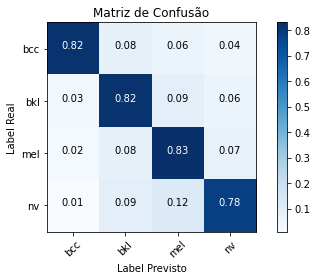

In [149]:
#Plot
plot_confusion_matrix(matriz, classes = classes, normalize = True ) 

In [150]:
#Relatório de Classificação
print(classification_report(Y_true_classes, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.93      0.82      0.87       100
           1       0.77      0.82      0.79       100
           2       0.75      0.83      0.79       100
           3       0.82      0.78      0.80       100

    accuracy                           0.81       400
   macro avg       0.82      0.81      0.81       400
weighted avg       0.82      0.81      0.81       400



In [152]:
#Salva o modelo
final_model.save("model/modelo_cancer_pele.h5")